In [1]:
import io
import os
import pickle
import random as rn
import warnings
from importlib import reload
from multiprocessing import cpu_count

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from gensim.models import Word2Vec
from IPython.display import display
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, \
        average_precision_score, ndcg_score, \
        label_ranking_average_precision_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle
from tensorflow.distribute import MirroredStrategy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant, GlorotUniform
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Conv1D, \
        GlobalMaxPooling1D, SpatialDropout1D, LSTM, GRU, Flatten, MaxPooling1D, \
        BatchNormalization, ReLU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import data
import models
import preprocessing

seed = 0
sns.set()

def reset_seed():
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    np.random.seed(seed)
    rn.seed(seed)
    tf.random.set_seed(seed)

## Extracting the data

In [2]:
# data.extract_data(extraction_dir="train",
#                   data_dir="data",
#                   data_zip_name="reuters-training-corpus.zip")

train_df = pd.read_pickle("train/data.pkl")

# train_df = data.get_docs_labels("train/REUTERS_CORPUS_2")
# train_df.to_pickle("train/data.pkl")

train_docs = train_df["doc"].values
train_labels = np.array(train_df["labels"].tolist())
n_labels = len(data.CODEMAP)

print(train_docs.shape)
print(train_labels.shape)
print(train_docs[2])
print(train_labels[2])

(299773,)
(299773, 126)
Toronto stocks end higher after volatile session. CHANGE				    CHANGE TSE	  5900.37    +50.15   HI 5900.37	    LO  5840.29 DJI	  6611.05    +27.57   GOLD (LONDON)   US$350.00 +1.90 FTSE100    4248.10    -64.80   GOLD (NY-COMEX) US$354.80 +0.70 NIKKEI    17869.59   -133.81   LME CASH NICKEL US$7659   +99.0 CANDLR	1.3883		 LME CASH ALUM   US$1602.0  -4.0 CAN 30-YR   107.41     -0.15   BRENT CRUDE     US$19.09  -0.27 --------------------MARKET COMMENT---------------------------- * Toronto stocks ended higher on Tuesday, buoyed by strength in golds and banking * Computer problems due to heavy trading in Bre-X Minerals hampered session * 84 million shares traded Toronto's key stock index ended higher on Tuesday as the saga of Bre-X Minerals Ltd and its Indonesian gold find continued to dominate Canada's biggest stock market. The TSE 300 Index climbed 50.15 points to close at 5900.37 in heavy turnover of 84.07 million shares worth C$1.4 billion. But the overall marke

## Preprocessing the documents

In [3]:
path_to_preprocessed_train_docs = "train/preprocessed_docs.pkl" # tokenization only
# path_to_preprocessed_train_docs = "train/preprocessed_docs_lemmatized_no_sw.pkl"

with open(path_to_preprocessed_train_docs, "rb") as f:
    preprocessed_train_docs = pickle.load(f)

# preprocessed_train_docs = preprocessing.preprocess_corpus(train_docs)
# with open(path_to_preprocessed_train_docs, "wb") as f:
#     pickle.dump(preprocessed_train_docs, f)

print(preprocessed_train_docs[2])

Toronto stocks end higher after volatile session . CHANGE CHANGE TSE 5900.37 +50.15 HI 5900.37 LO 5840.29 DJI 6611.05 +27.57 GOLD ( LONDON ) US$ 350.00 +1.90 FTSE100 4248.10 -64.80 GOLD ( NY - COMEX ) US$ 354.80 +0.70 NIKKEI 17869.59 -133.81 LME CASH NICKEL US$ 7659 +99.0 CANDLR 1.3883 LME CASH ALUM US$ 1602.0 -4.0 CAN 30-YR 107.41 -0.15 BRENT CRUDE US$ 19.09 -0.27 --------------------MARKET COMMENT---------------------------- * Toronto stocks ended higher on Tuesday , buoyed by strength in golds and banking * Computer problems due to heavy trading in Bre - X Minerals hampered session * 84 million shares traded Toronto 's key stock index ended higher on Tuesday as the saga of Bre - X Minerals Ltd and its Indonesian gold find continued to dominate Canada 's biggest stock market . The TSE 300 Index climbed 50.15 points to close at 5900.37 in heavy turnover of 84.07 million shares worth C$ 1.4 billion . But the overall market was mixed with declining issues narrowly outpacing advances 476

## Representing the documents as token index sequences

In [4]:
docs = preprocessed_train_docs
n_vocabulary = 20000

In [5]:
tokenizer = Tokenizer(num_words=n_vocabulary, filters="", lower=False)
tokenizer.fit_on_texts(docs)
word_idx = tokenizer.word_index
if n_vocabulary is None:
    n_vocabulary = len(word_idx)

print(n_vocabulary)

20000


In [6]:
n_sequence = 256

sequences = tokenizer.texts_to_sequences(docs)
if n_sequence is None:
    n_sequence = max([len(s) for s in sequences])
sequence_lengths = [min(len(s), n_sequence) for s in sequences]
sequences = pad_sequences(sequences,
                          maxlen=n_sequence,
                          padding="post",
                          truncating="post")

print(n_sequence)
print(sequences.shape)
print(sequences[2][:100])

256
(299773, 256)
[ 2112   217   137   145    52  2639   593     2  3714  3714  9473  8514
  9051  4802    14  2981    13   587  4802    14  3274     7  3355    13
   587 15304  1660  5594 16940   587  1660  5594   587 14783  1709 11671
 15729 13077   587    38  2112   217   226   145    12    85     3  5774
    23  1043     6 11672     9   809    38  3318   700   167     4   901
   181     6  3495     7  1927  6603  9271   593    38  4214    31    75
   418  2112    15   435   150   180   226   145    12    85    30     1
 15801     5  3495     7  1927  6603   200     9    32  1780   441  1151
   598     4  7599   622]


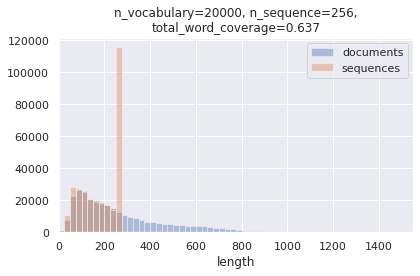

In [7]:
doc_lengths = [len(doc.split()) for doc in docs]

sns.distplot(doc_lengths,
             bins=np.arange(0, 2500, 25),
             kde=False,
             label="documents")
sns.distplot(sequence_lengths,
             bins=np.arange(0, 2500, 25),
             kde=False,
             label="sequences")
total_word_coverage = np.round(np.sum(sequence_lengths) / np.sum(doc_lengths), 3)
plt.title(f"n_vocabulary={n_vocabulary}, n_sequence={n_sequence},\n"
          f"total_word_coverage={total_word_coverage}")
plt.xlim(0, 1550)
plt.xlabel("length")
plt.legend()
plt.tight_layout()
plt.show()

## Word embeddings

In [8]:
n_embedding = 300 # 300 required by FastText

### Word2Vec

In [9]:
reset_seed()

window = 5
w2v_path = f"data/w2v_{window}_{n_embedding}_train.model"

try:
    w2v_embedding_model = Word2Vec.load(w2v_path)
except:
    w2v_embedding_model = Word2Vec(sentences=[s.split() for s in docs],
                                   size=n_embedding, 
                                   window=window,
                                   min_count=5,
                                   sg=1,
                                   workers=cpu_count(),
                                   seed=seed)
    w2v_embedding_model.save(w2v_path)

print(len(list(w2v_embedding_model.wv.vocab)))
print(w2v_embedding_model.wv.index2entity[:100])

191252
['the', '.', ',', 'to', 'of', 'in', '-', 'a', 'and', '"', 'said', 'on', ')', '(', "'s", 'for', 'The', 'at', 'was', '$', 'that', 'is', 'by', 'with', 'from', 'percent', 'it', 'be', '/', 'as', 'million', 'its', 'will', 'has', '--', 'were', 'not', '*', 'would', 'year', 'are', 'have', 'an', 'he', 'which', ':', 'had', 'market', 'up', 'A', 'but', 'after', 'N', 'this', 'company', 'one', 'been', 'U.S.', 'billion', 'also', 'government', 'last', 'or', '1997', 'two', 'their', 'they', 'first', 'over', 'new', '1', 'his', 'more', 'June', 'shares', 'about', 'week', 'It', 'than', 'share', 'Bank', 'who', 'I', '1996', 'Tuesday', '%', 'per', 'Wednesday', 'May', 'we', 'expected', 'July', 'Thursday', 'Monday', 'We', 'some', 'Friday', 'down', 'could', 'three']


### FastText

In [10]:
def load_vectors(fname): # from https://fasttext.cc/docs/en/english-vectors.html
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float, tokens[1:])))
    return data

ft_embedding_model = load_vectors("data/crawl-300d-2M.vec")

token_iter = iter(ft_embedding_model)
print([next(token_iter) for i in range(100)])

[',', 'the', '.', 'and', 'to', 'of', 'a', 'in', 'is', 'for', 'that', 'I', 'it', 'on', 'with', ')', ':', '"', '(', 'The', 'you', 'was', 'are', 'or', 'this', 'as', 'have', 'at', 'from', '!', "'s", 'but', 'by', 'not', '?', 'your', 'all', '/', 'be', 'we', 'my', 'one', '-', 'will', 'they', 'so', 'which', '”', '“', 'has', '...', 'just', 'he', 'their', 'can', 'about', 'his', 'our', ';', 'when', 'more', 'had', 'do', 'some', 'time', 'like', 'also', 'there', 'them', 'get', 'what', 'out', "'", 'me', 'her', 'an', 'were', 'This', 'It', 'up', 'would', 'if', 'who', 'new', 'only', 'A', '–', 'people', 'any', 'We', 'make', 'other', 'In', 'then', 'its', 'use', 'said', 'now', 'no', 'first']


### Embedding matrices

In [11]:
def create_embedding_matrix(embedding_model):
    embedding_matrix = np.zeros((n_vocabulary, n_embedding))
    unknown_token_count = 0
    for token, i in word_idx.items():
        if i >= n_vocabulary:
            continue
        if token in embedding_model:
            embedding_matrix[i] = embedding_model[token]
        else:
            embedding_matrix[i] = np.zeros(n_embedding)
            unknown_token_count += 1

    print(unknown_token_count)
    print(embedding_matrix.shape)
    print(embedding_matrix[1][:50])

    return embedding_matrix

In [12]:
w2v_embedding_matrix = create_embedding_matrix(w2v_embedding_model)

0
(20000, 300)
[ 0.0552584   0.01123355  0.05852774  0.03515947  0.11631026 -0.02895849
  0.17440622 -0.07505921  0.31014937  0.18220782 -0.153667    0.12877345
 -0.16599374 -0.03246057  0.14044979  0.0378183   0.01423781  0.20776965
  0.25640684 -0.29507896  0.05467122 -0.19314985  0.16100715  0.16121837
  0.10513832 -0.14126474 -0.10564382  0.07230753 -0.2635389   0.11694992
  0.22365659  0.10568991 -0.20522533 -0.00804843 -0.11998951  0.02327573
  0.23315957 -0.22042817 -0.04073263 -0.07091328 -0.26871315  0.40764555
 -0.12853378 -0.1205063  -0.04120149 -0.03833532  0.09974524 -0.1054061
 -0.04243345 -0.16846807]


In [13]:
ft_embedding_matrix = create_embedding_matrix(ft_embedding_model)

687
(20000, 300)
[ 0.0231  0.017   0.0157 -0.0773  0.1088  0.0031 -0.1487 -0.2672 -0.0357
 -0.0487  0.0807  0.1532 -0.0739 -0.0291 -0.0445 -0.0014  0.1014  0.0186
 -0.0253  0.02   -0.0026 -0.0179  0.0005  0.0054 -0.0134  0.0233 -0.0755
 -0.0156  0.0415 -0.4985  0.041  -0.0616  0.0047  0.0325 -0.0162 -0.0172
  0.0988  0.0766 -0.0796 -0.0345  0.0124 -0.1007 -0.0292 -0.0762 -0.1261
 -0.0531  0.0424  0.0144 -0.0683  0.2859]


## Shuffling the data

In [14]:
n_samples = None
x_train, y_train = shuffle(sequences,
                           train_labels,
                           random_state=seed,
                           n_samples=n_samples)

## Cross-evaluating the models

In [15]:
def cross_evaluate(model_initializer, embedding_matrix, loss, batch_size=256):
    kfold = KFold(n_splits=5)
    cv_scores = []

    model_initializer(embedding_matrix, n_vocabulary, n_embedding, n_sequence,
                      n_labels, loss).summary()

    for train, val in kfold.split(x_train, y_train):
        model = model_initializer(embedding_matrix, n_vocabulary, n_embedding,
                                  n_sequence, n_labels, loss)
        es = EarlyStopping(patience=3, verbose=1, restore_best_weights=True)
        history = model.fit(x_train[train],
                            y_train[train],
                            batch_size=batch_size,
                            epochs=100,
                            verbose=1,
                            validation_data=(x_train[val], y_train[val]),
                            callbacks=[es])

        y_pred_prob = model.predict(x_train[val], batch_size=batch_size, verbose=1)
        y_pred = np.round(y_pred_prob)

        scores = {}
        scores["accuracy"] = accuracy_score(y_train[val], y_pred)
        scores["F1 (macro)"] = f1_score(y_train[val], y_pred, average="macro")
        scores["F1 (micro)"] = f1_score(y_train[val], y_pred, average="micro")
        scores["LRAP"] = label_ranking_average_precision_score(y_train[val],
                                                               y_pred_prob)
        scores["NDCG"] = ndcg_score(y_train[val], y_pred_prob)
        cv_scores.append(scores)
        print(scores)

    cv_scores_df = pd.DataFrame(cv_scores)
    display(cv_scores_df)
    print(cv_scores_df.mean())

In [30]:
reload(models)

<module 'models' from '/projappl/project_2002961/DL-2020-Shakespeare/models.py'>

In [18]:
reset_seed()
cross_evaluate(models.init_cnn_bi_lstm_1, ft_embedding_matrix, "binary_crossentropy")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1
937/937 [==============================] - 31s 34ms/step - loss: 0.0396 - val_loss: 0.0222
Epoch 2/100
937/937 [==============================] - 28s 30ms/step - loss: 0.0199 - val_loss: 0.0183
Epoch 3/100
937/937 [==============================] - 28s 30ms/step - loss: 0.0174 - val_loss: 0.0171
Epoch 4/100
937/937 [==============================] - 28s 30ms/step - loss: 0.0161 - val_loss: 0.0163
Epoch 5/100
937/937 [==============================] - 28s 30ms/step - loss: 0.0153 - val_loss: 0.0161
Epoch 6/100
937/937 [==============================] - 28s 30ms/step - loss: 0.0146 - val_loss: 0.0159
Epoch 7/100
937/937 [==============================] - 28s 30ms/step - loss: 0.0141 - val_loss: 0.0155
Epoch 8/100
937/937 [==============================] - 28s 30ms/step - loss: 0.0136 - val_loss: 0.0156
Epoc

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.691369,0.603987,0.892458,0.959444,0.976422
1,0.682745,0.593481,0.890021,0.957891,0.975527
2,0.684163,0.596165,0.890360,0.958455,0.976124
3,0.688745,0.601835,0.892834,0.958838,0.976272
4,0.686576,0.604793,0.890868,0.958368,0.975765


accuracy      0.686720
F1 (macro)    0.600052
F1 (micro)    0.891308
LRAP          0.958599
NDCG          0.976022
dtype: float64


In [19]:
reset_seed()
cross_evaluate(models.init_cnn_bi_lstm_1, ft_embedding_matrix, "mean_squared_error")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 256, 300)          6000000   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 255, 400)          240400    
_________________________________________________________________
batch_normalization_12 (Batc (None, 255, 400)          1600      
_________________________________________________________________
re_lu_12 (ReLU)              (None, 255, 400)          0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 127, 400)          0         
_______

937/937 [==============================] - 28s 30ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 9/100
937/937 [==============================] - 28s 30ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 10/100
937/937 [==============================] - 28s 30ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 11/100
937/937 [==============================] - 28s 29ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 12/100
937/937 [==============================] - 28s 30ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 13/100
937/937 [==============================] - 28s 30ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 14/100
937/937 [==============================] - 28s 30ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 00014: early stopping
235/235 [==============================] - 2s 9ms/step
{'accuracy': 0.692552747894254, 'F1 (macro)': 0.5840406931765899, 'F1 (micro)': 0.8913256522314925, 'LRAP': 0.9560808931302488, 'NDCG': 0.9745814503258573}
INFO:tensorflow:Using MirroredStrategy with dev

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.695422,0.593923,0.892425,0.957130,0.975069
1,0.699008,0.595469,0.893945,0.957302,0.975009
2,0.692553,0.584041,0.891326,0.956081,0.974581
3,0.696467,0.595912,0.893485,0.957027,0.975162
4,0.691764,0.577556,0.892325,0.956507,0.974689


accuracy      0.695043
F1 (macro)    0.589380
F1 (micro)    0.892701
LRAP          0.956809
NDCG          0.974902
dtype: float64


In [25]:
reset_seed()
cross_evaluate(models.init_cnn_bi_lstm_9, ft_embedding_matrix, "binary_crossentropy")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 256, 300)          6000000   
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 255, 400)          240400    
_________________________________________________________________
batch_normalization_52 (Batc (None, 255, 400)          1600      
_________________________________________________________________
re_lu_44 (ReLU)              (None, 255, 400)          0         
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 127, 400)          0         
______

Epoch 00012: early stopping
235/235 [==============================] - 2s 9ms/step
{'accuracy': 0.6842298390459511, 'F1 (macro)': 0.5473916988829527, 'F1 (micro)': 0.8884200232779376, 'LRAP': 0.9558886627707551, 'NDCG': 0.974769574086155}
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Epoch 1/100
937/937 [==============================] - 34s 36ms/step - loss: 0.0485 - val_loss: 0.0236
Epoch 2/100
937/937 [==============================] - 28s 30ms/step - loss: 0.0238 - val_loss: 0.0195
Epoch 3/100
937/937 [==============================] - 28s 30ms/step - loss: 0.0206 - val_loss: 0.0178
Epoch 4/100
937/937 [==============================] - 28s 30ms/step - loss: 0.0190 - val_loss: 0.0173
Epoch 5/100
937/937 [==============================] - 28s 30ms/step - loss: 0.0179 - val_loss: 0.0166
E

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.688633,0.561688,0.890106,0.957601,0.975427
1,0.691919,0.571801,0.891717,0.958008,0.975559
2,0.684230,0.547392,0.888420,0.955889,0.974770
3,0.684158,0.545023,0.888916,0.955299,0.974323
4,0.689112,0.557016,0.889855,0.957131,0.975120


accuracy      0.687610
F1 (macro)    0.556584
F1 (micro)    0.889803
LRAP          0.956786
NDCG          0.975040
dtype: float64


In [31]:
reset_seed()
cross_evaluate(models.init_cnn_bi_gru_1, ft_embedding_matrix, "binary_crossentropy")

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 256, 300)          6000000   
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 255, 400)          240400    
_________________________________________________________________
batch_normalization_72 (Batc (None, 255, 400)          1600      
_________________________________________________________________
re_lu_64 (ReLU)              (None, 255, 400)          0         
_________________________________________________________________
max_pooling1d_72 (MaxPooling (None, 127, 400)          0         
_________________________________________________________________
dropout_76 (Dropout)         (None, 127, 400)          0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 126, 500)        

937/937 [==============================] - 72s 77ms/step - loss: 0.0129 - val_loss: 0.0153
Epoch 11/100
937/937 [==============================] - 72s 77ms/step - loss: 0.0125 - val_loss: 0.0153
Epoch 00011: early stopping
235/235 [==============================] - 6s 24ms/step
{'accuracy': 0.6846081996197084, 'F1 (macro)': 0.6019218705595674, 'F1 (micro)': 0.8919014325681379, 'LRAP': 0.9582990918499233, 'NDCG': 0.9760143694889738}
Epoch 1/100
937/937 [==============================] - 73s 78ms/step - loss: 0.0357 - val_loss: 0.0205
Epoch 2/100
937/937 [==============================] - 72s 77ms/step - loss: 0.0189 - val_loss: 0.0176
Epoch 3/100
937/937 [==============================] - 72s 77ms/step - loss: 0.0168 - val_loss: 0.0168
Epoch 4/100
937/937 [==============================] - 72s 77ms/step - loss: 0.0158 - val_loss: 0.0163
Epoch 5/100
937/937 [==============================] - 72s 77ms/step - loss: 0.0150 - val_loss: 0.0159
Epoch 6/100
937/937 [============================

,accuracy,F1 (macro),F1 (micro),LRAP,NDCG
0,0.688500,0.601217,0.891365,0.959230,0.976331
1,0.689317,0.597220,0.892367,0.959445,0.976228
2,0.683830,0.594697,0.889572,0.958555,0.976181
3,0.684608,0.601922,0.891901,0.958299,0.976014
4,0.679988,0.591682,0.888977,0.957462,0.975247


accuracy      0.685248
F1 (macro)    0.597348
F1 (micro)    0.890837
LRAP          0.958598
NDCG          0.976000
dtype: float64
